In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

Load Data, split into train test validate parts


In [52]:
from pathlib import Path
root = Path('/content/')
yes_files = list(root.rglob('yes_*'))
no_files = list(root.rglob('no_*'))
food_files = list(root.rglob('food_*'))
water_files = list(root.rglob('water_*'))
bg_noise = list(root.rglob('backgroundnoise_*'))

import pandas as pd
import numpy as np


def create_data_frame(file_locations: list, label: str, label_id: int,
                      start_cut: int = 0, end_cut: int = 0):
    """
    Load BCI time series files into a DataFrame and trim a fixed number of rows
    from the start and end of each trial.

    Parameters
    ----------
    file_locations : list
        List of CSV file paths for each trial.
    label : str
        Label for the trial.
    label_id : int
        Numeric label ID.
    start_cut : int
        Number of rows to remove from the start of each trial.
    end_cut : int
        Number of rows to remove from the end of each trial.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
            - 'label' (str)
            - 'label_id' (int)
            - 'trial' (int)
            - 'data' (pd.DataFrame of features + timestamp)
    """
    import pandas as pd
    import numpy as np

    feature_names = [f"interface_{i+1}" for i in range(8)] + ["timestamp"]
    records = []

    for i, file in enumerate(file_locations):
        df = pd.read_csv(file, header=None)
        df["timestamp"] = np.arange(len(df))
        df.columns = feature_names

        # Trim start and end
        df = df.iloc[start_cut:len(df)-end_cut].reset_index(drop=True)

        records.append({
            "label": label,
            "label_id": label_id,
            "trial": i,
            "data": df
        })

    return pd.DataFrame(records)



label_to_id = {"water":0, "food":1, "bg_noise":2}
# label_to_id = {"no":0, "yes":1, "water":2}

# yes_data = create_data_frame(yes_files, "yes", label_to_id["yes"], start_cut=125, end_cut=60)
# no_data  = create_data_frame(no_files,  "no",  label_to_id["no"],  start_cut=125, end_cut=60)
food_data = create_data_frame(food_files, "food", label_to_id["food"], start_cut=125, end_cut=60)
water_data = create_data_frame(water_files, "water", label_to_id["water"], start_cut=125, end_cut=60)
background_noise = create_data_frame(bg_noise, "bg_noise", label_to_id["bg_noise"], start_cut=125, end_cut=60)



data = pd.concat([food_data, water_data,background_noise], ignore_index=True)
# data = pd.concat([yes_data, no_data, water_data], ignore_index=True)



print(data)
print()
data.iloc[0]["data"]


        label  label_id  trial  \
0        food         1      0   
1        food         1      1   
2        food         1      2   
3        food         1      3   
4        food         1      4   
..        ...       ...    ...   
174  bg_noise         2     35   
175  bg_noise         2     36   
176  bg_noise         2     37   
177  bg_noise         2     38   
178  bg_noise         2     39   

                                                  data  
0         interface_1  interface_2  interface_3  in...  
1         interface_1  interface_2  interface_3  in...  
2         interface_1  interface_2  interface_3  in...  
3         interface_1  interface_2  interface_3  in...  
4         interface_1  interface_2  interface_3  in...  
..                                                 ...  
174       interface_1  interface_2  interface_3  in...  
175       interface_1  interface_2  interface_3  in...  
176       interface_1  interface_2  interface_3  in...  
177       interface_1

interface_1  interface_2  interface_3  interface_4  interface_5  \
0       1.961118     1.916765     2.425796     2.538626     1.543195   
1       3.935043     3.391734     4.217380     4.082739     2.917843   
2       2.630963     1.699224     2.161482     2.334897     1.108579   
3       1.180177     0.868006    -0.295094    -0.206544    -0.174478   
4       0.653676     1.678287    -0.242710    -1.148505    -0.194523   
..           ...          ...          ...          ...          ...   
435    -0.313153    -1.253576    -0.921399    -1.139954    -3.007514   
436     1.519270    -0.259630     0.969525     0.935029    -1.078556   
437     3.125193     1.115698     2.384269     1.646556     1.901947   
438     4.428125     3.240458     4.119492     2.939768     3.992136   
439     0.784872     0.536438     0.993394     0.412932     1.330400   

     interface_6  interface_7  interface_8  timestamp  
0       1.009492     0.532312    -0.130956        125  
1       2.351572     1.789004     1.861330        126  
2       0.316298     1.125321     1.151582        127  
3      -1.777016     0.167831    -0.482448        128  
4      -1.753114    -0.736462    -1.105686        129  
..           ...          ...          ...        ...  
435    -1.611278    -1.845098    -1.132494        560  
436    -0.283013    -0.333141     0.850649        561  
437     0.981447     1.647936     1.105108        562  
438     2.457015     3.156723     0.780741        563  
439    -0.288963    -0.193778    -1.470119        564  

[440 rows x 9 columns]

Preprocessing Here

In [1]:
!pip install "git+https://github.com/MindsApplied/Minds_AI_EEG_Filter@main"

import mindsai_filter_python as mai


  Cloning https://github.com/MindsApplied/Minds_AI_EEG_Filter (to revision main) to /tmp/pip-req-build-y578w3on
  Running command git clone --filter=blob:none --quiet https://github.com/MindsApplied/Minds_AI_EEG_Filter /tmp/pip-req-build-y578w3on
  Resolved https://github.com/MindsApplied/Minds_AI_EEG_Filter to commit c21c032085cbf7cdf29e65cdd7101186b26187ca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [53]:
import numpy as np
import pandas as pd
import mindsai_filter_python as mai

def apply_mindsai_filter_to_df(df, tailoring_lambda=1.25e-29):
    """
    Applies the MindsAI EEG filter to each trial in the DataFrame.
    Preserves original column names if the 'data' cell is a DataFrame.
    """
    df_filtered = df.copy()

    for i in range(len(df_filtered)):
        trial = df_filtered.at[i, "data"]

        # If trial is a DataFrame, preserve its columns
        if isinstance(trial, pd.DataFrame):
            col_names = trial.columns
            features = trial.iloc[:, :8].values
            timestamp = trial.iloc[:, -1].values
        else:
            # Default column names if original has none
            col_names = [f"interface_{j+1}" for j in range(8)] + ["timestamp"]
            features = trial[:, :8]
            timestamp = trial[:, -1]

        # Transpose to (channels, time)
        features_T = features.T

        # Apply MindsAI filter
        filtered_T = mai.mindsai_python_filter(features_T, tailoring_lambda)

        # Transpose back
        filtered_features = np.array(filtered_T).T

        # Combine filtered features with timestamp
        filtered_trial = np.hstack([filtered_features, timestamp.reshape(-1, 1)])

        # Recreate DataFrame with preserved column names
        filtered_df = pd.DataFrame(filtered_trial, columns=col_names)

        # Save back
        df_filtered.at[i, "data"] = filtered_df

    return df_filtered


filtered_data = apply_mindsai_filter_to_df(data)
print(filtered_data)


        label  label_id  trial  \
0        food         1      0   
1        food         1      1   
2        food         1      2   
3        food         1      3   
4        food         1      4   
..        ...       ...    ...   
174  bg_noise         2     35   
175  bg_noise         2     36   
176  bg_noise         2     37   
177  bg_noise         2     38   
178  bg_noise         2     39   

                                                  data  
0         interface_1  interface_2  interface_3  in...  
1         interface_1  interface_2  interface_3  in...  
2         interface_1  interface_2  interface_3  in...  
3         interface_1  interface_2  interface_3  in...  
4         interface_1  interface_2  interface_3  in...  
..                                                 ...  
174       interface_1  interface_2  interface_3  in...  
175       interface_1  interface_2  interface_3  in...  
176       interface_1  interface_2  interface_3  in...  
177       interface_1

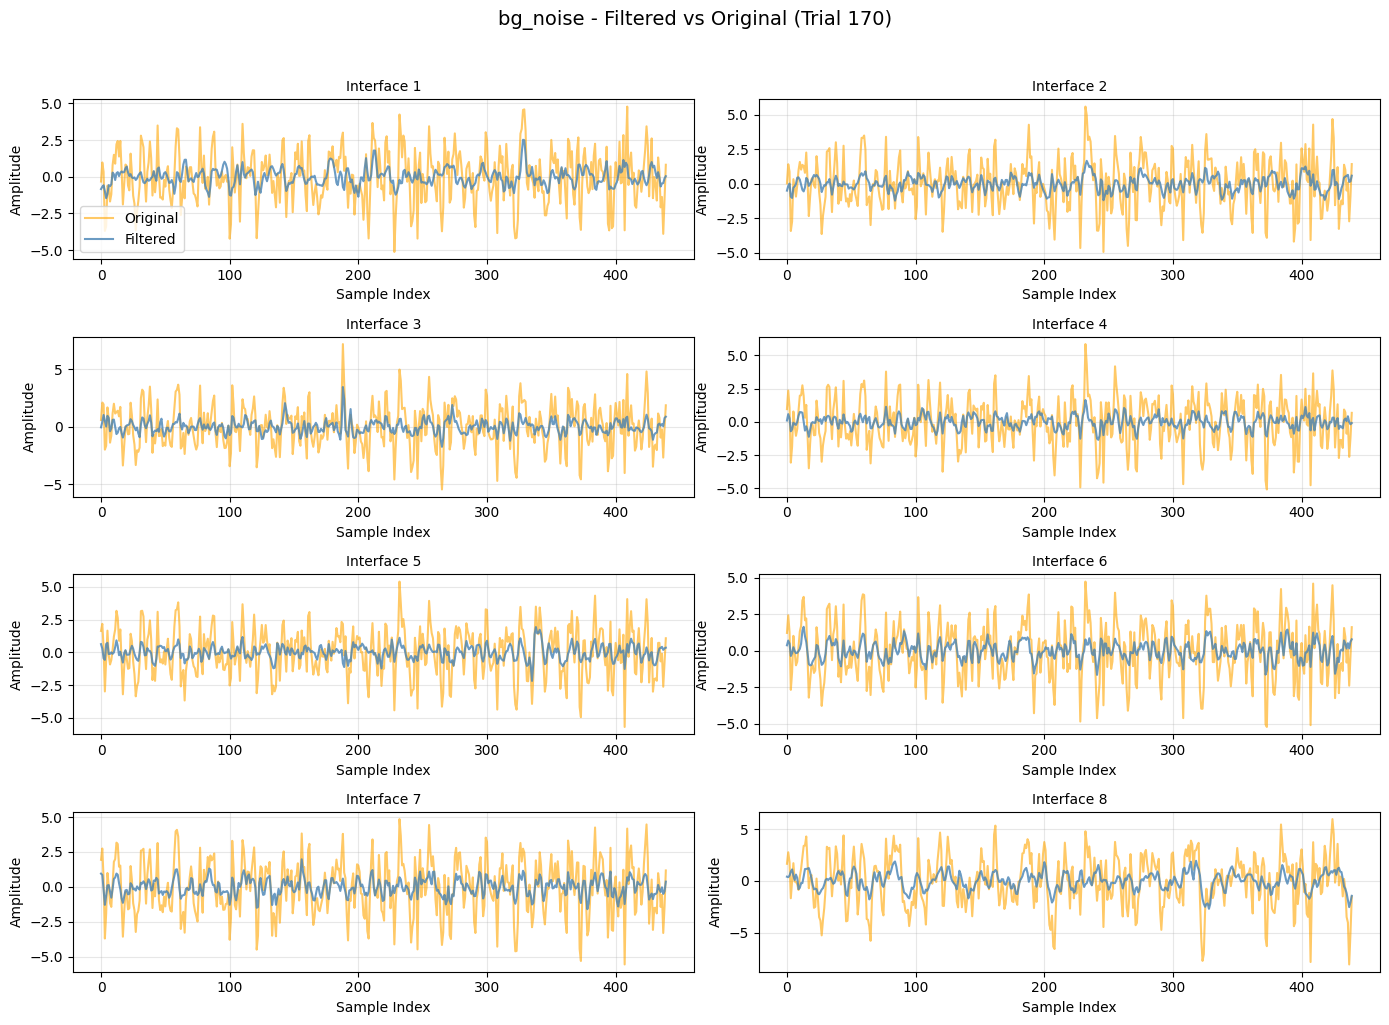

In [54]:
import matplotlib.pyplot as plt


def plot_filtered_vs_original(original_df, filtered_df, trial_idx=0, label_name=""):
    """
    Plots  EEG signals before and after filtering for a given trial.

    Parameters
    ----------
    original_df : pd.DataFrame
    filtered_df : pd.DataFrame
    trial_idx : int, optional
        Which trial to plot
    label_name : str
    """

    # Extract the corresponding trials
    original = original_df.iloc[trial_idx]["data"]
    filtered = filtered_df.iloc[trial_idx]["data"]

    # Handle pandas/numpy cases
    if not isinstance(original, np.ndarray):
        original = original.values
    if not isinstance(filtered, np.ndarray):
        filtered = filtered.values

    # Extract 8 feature columns (skip timestamp)
    orig_features = original[:, :8]
    filt_features = filtered[:, :8]

    time = np.arange(orig_features.shape[0])  # sample index

    # Plot all 8 interfaces
    plt.figure(figsize=(14, 10))
    for i in range(8):
        plt.subplot(4, 2, i + 1)
        plt.plot(time, orig_features[:, i], alpha=0.6, label="Original", color="orange")
        plt.plot(time, filt_features[:, i], alpha=0.8, label="Filtered", color="steelblue")
        plt.title(f"Interface {i+1}", fontsize=10)
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(alpha=0.3)
        if i == 0:
            plt.legend()

    plt.suptitle(f"{label_name} - Filtered vs Original (Trial {trial_idx})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


plot_filtered_vs_original(data, filtered_data, trial_idx=170, label_name="bg_noise")


TRIAL INDEX = 0


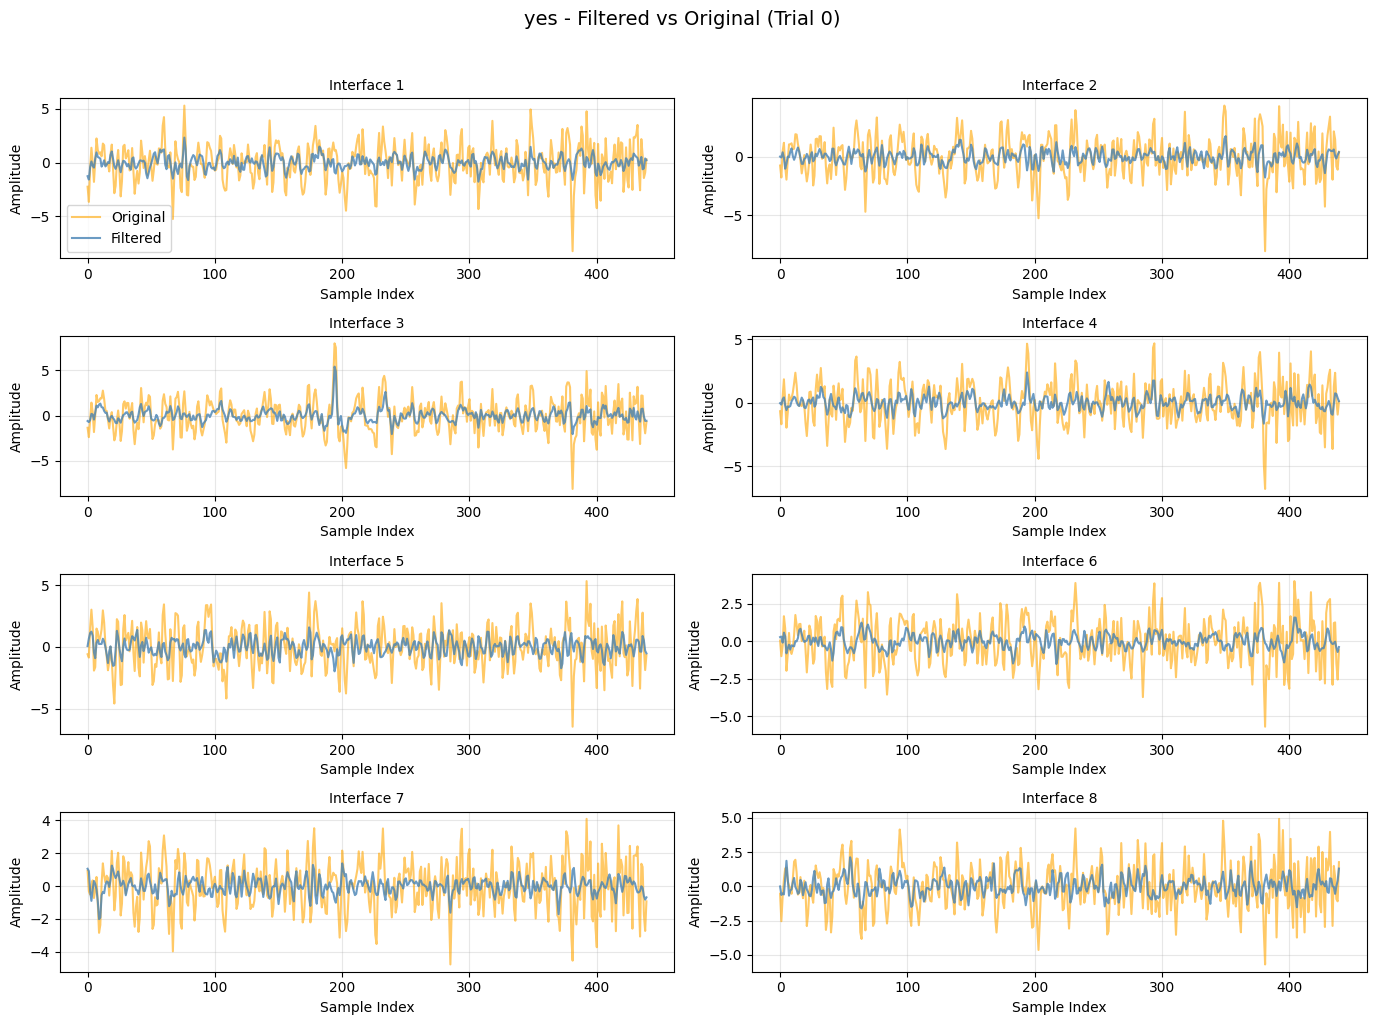



TRIAL INDEX = 1


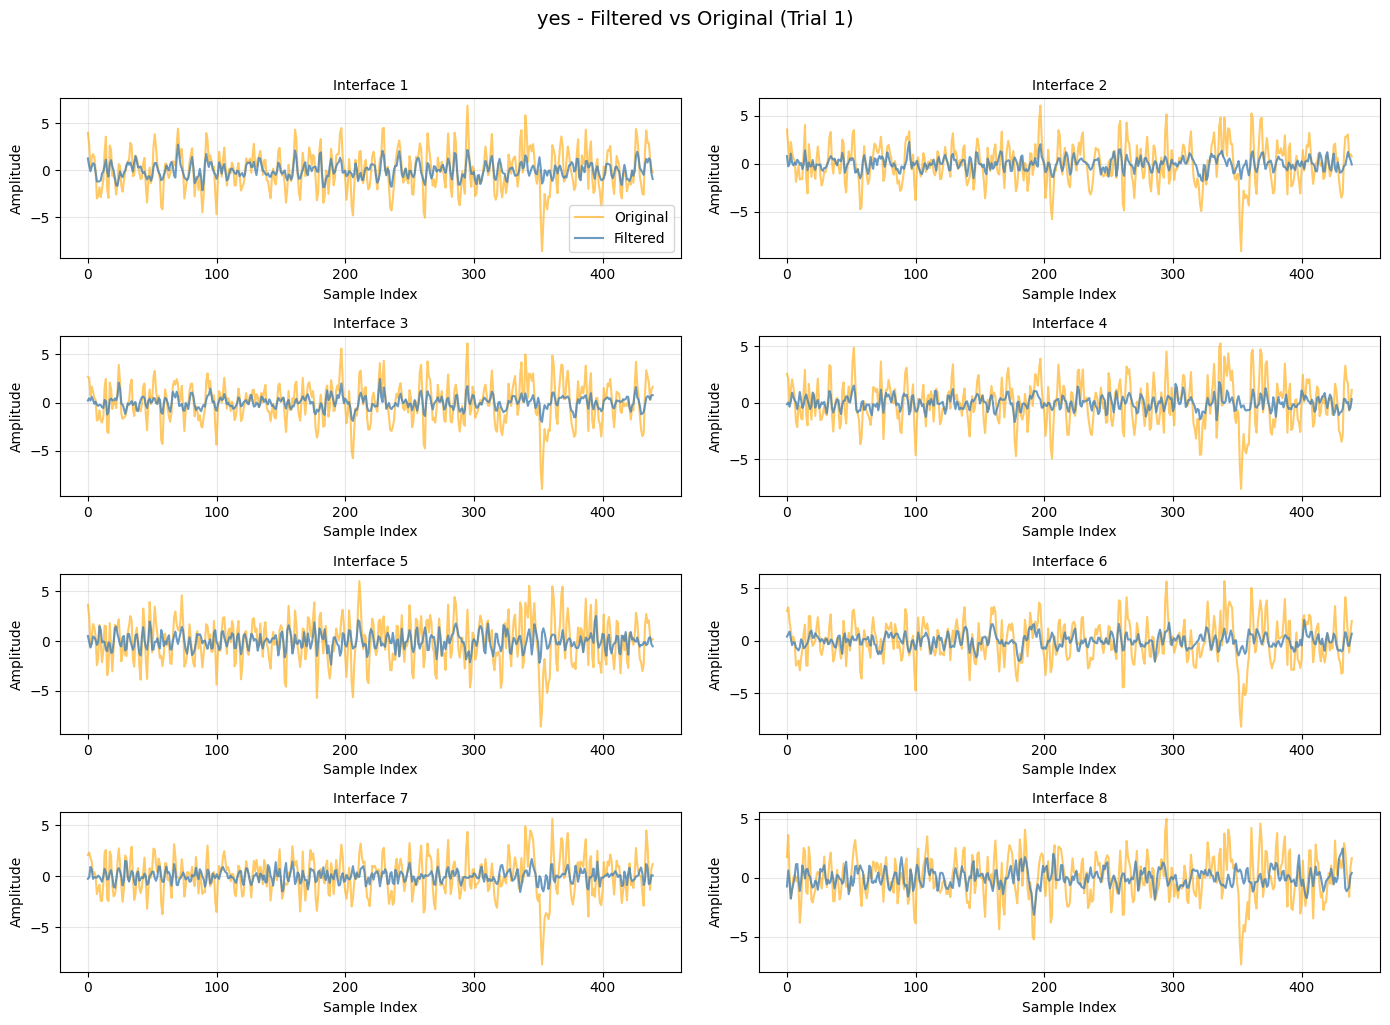



TRIAL INDEX = 2


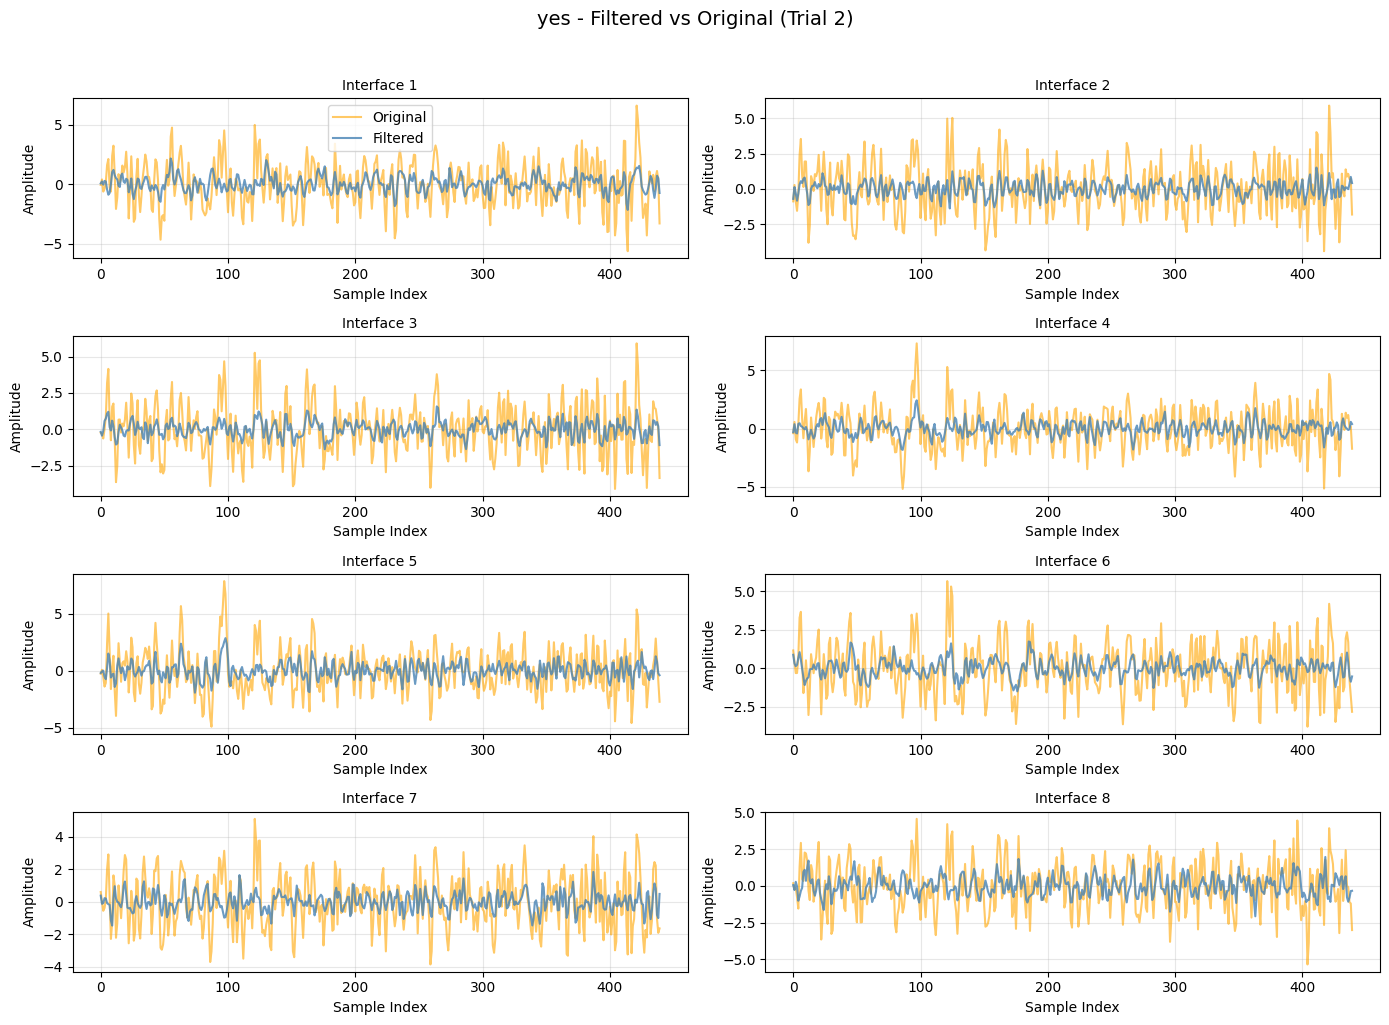



TRIAL INDEX = 3


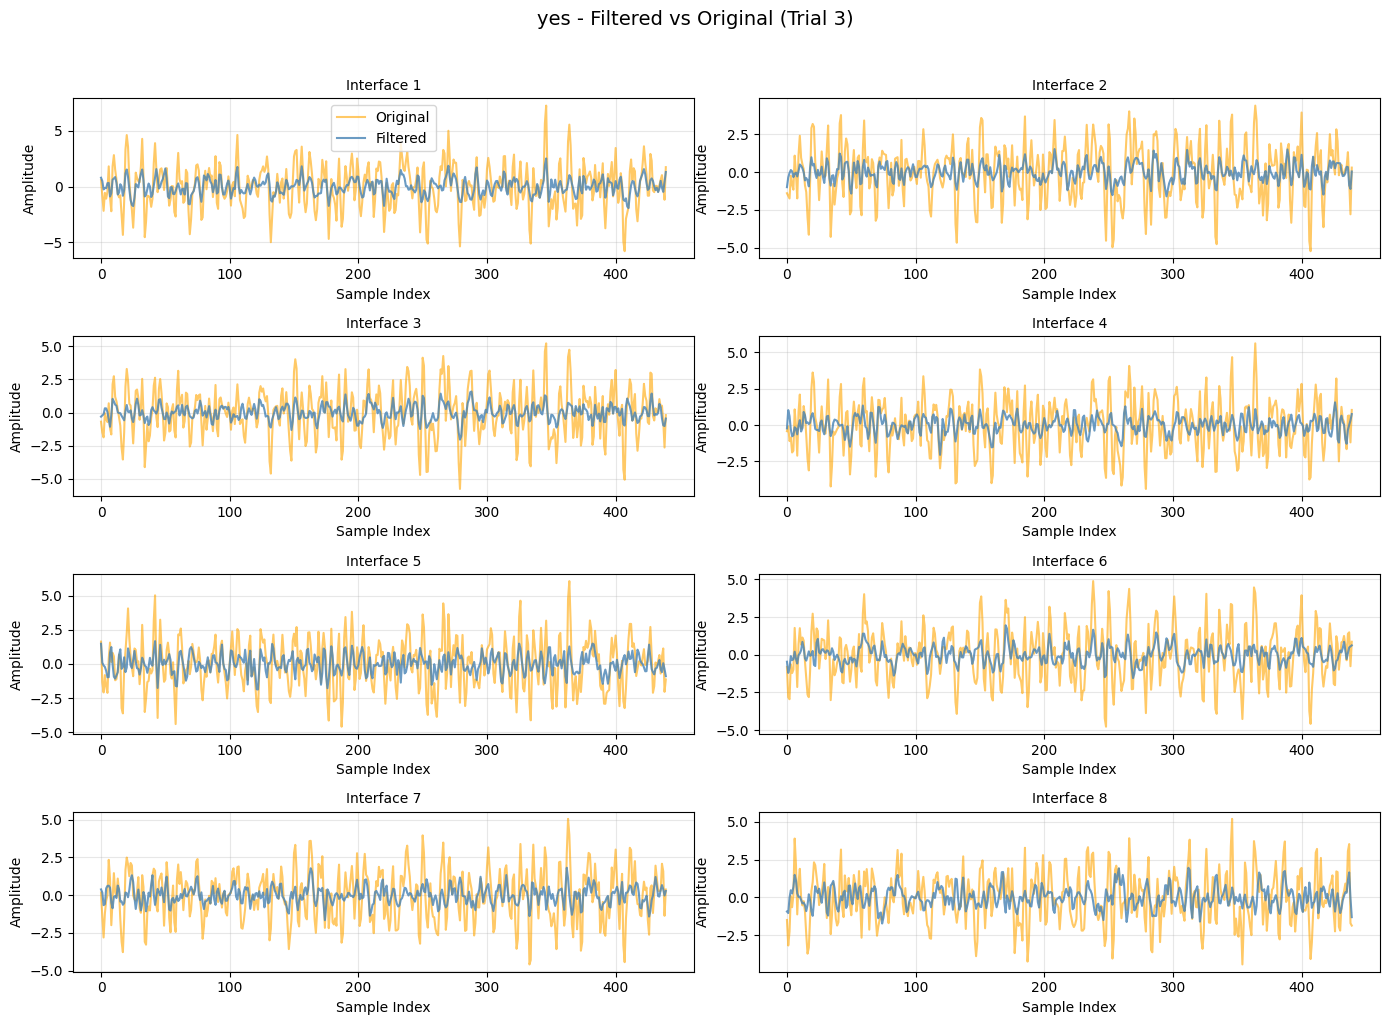



TRIAL INDEX = 4


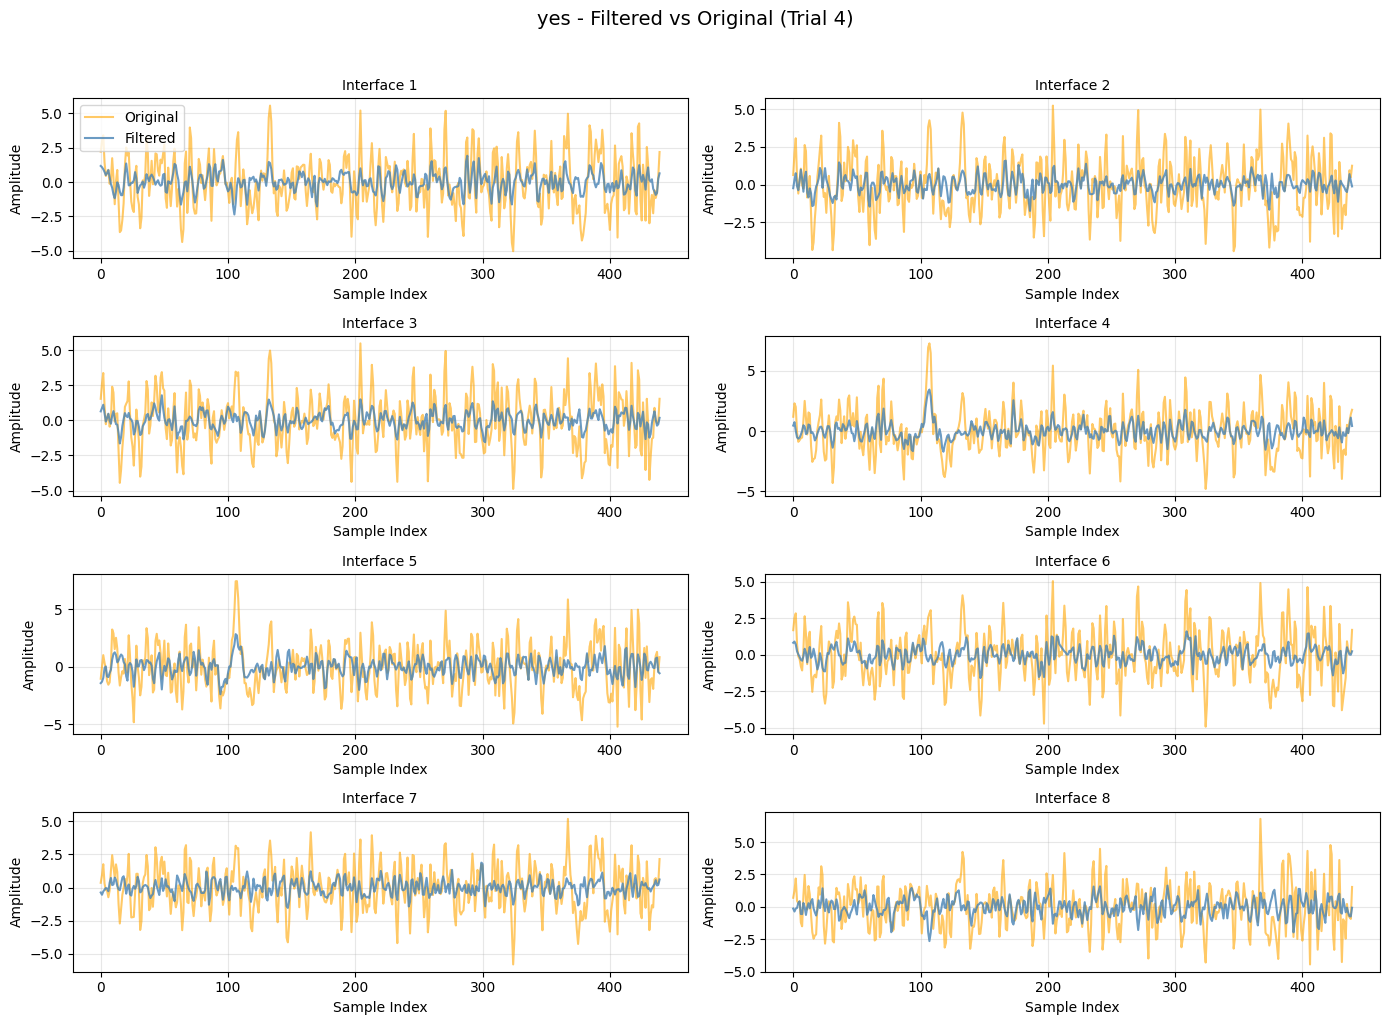



TRIAL INDEX = 5


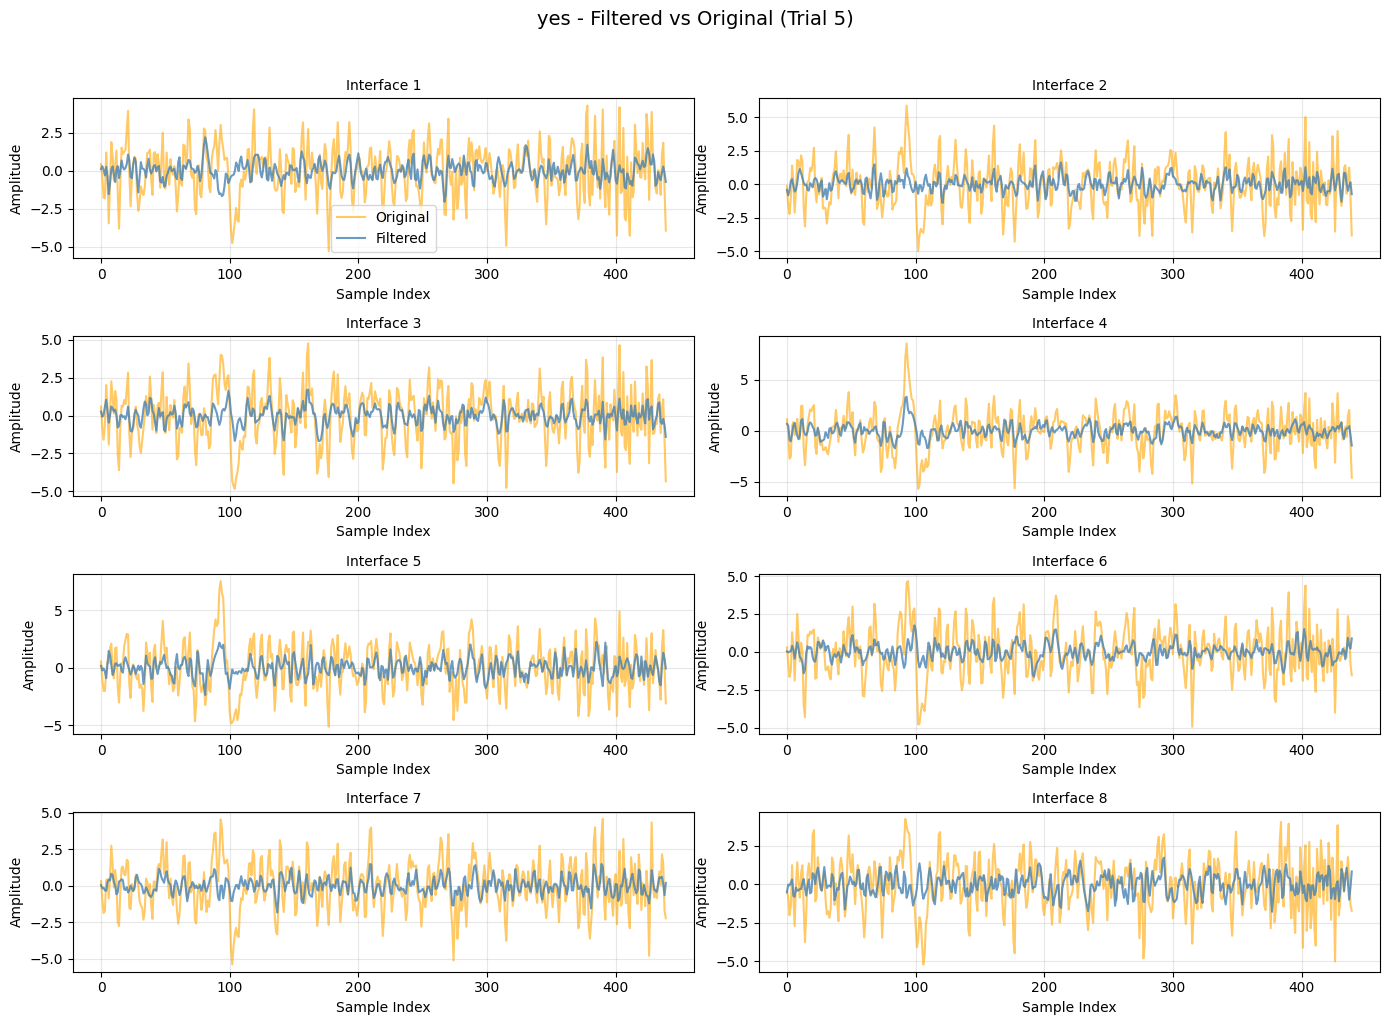



TRIAL INDEX = 6


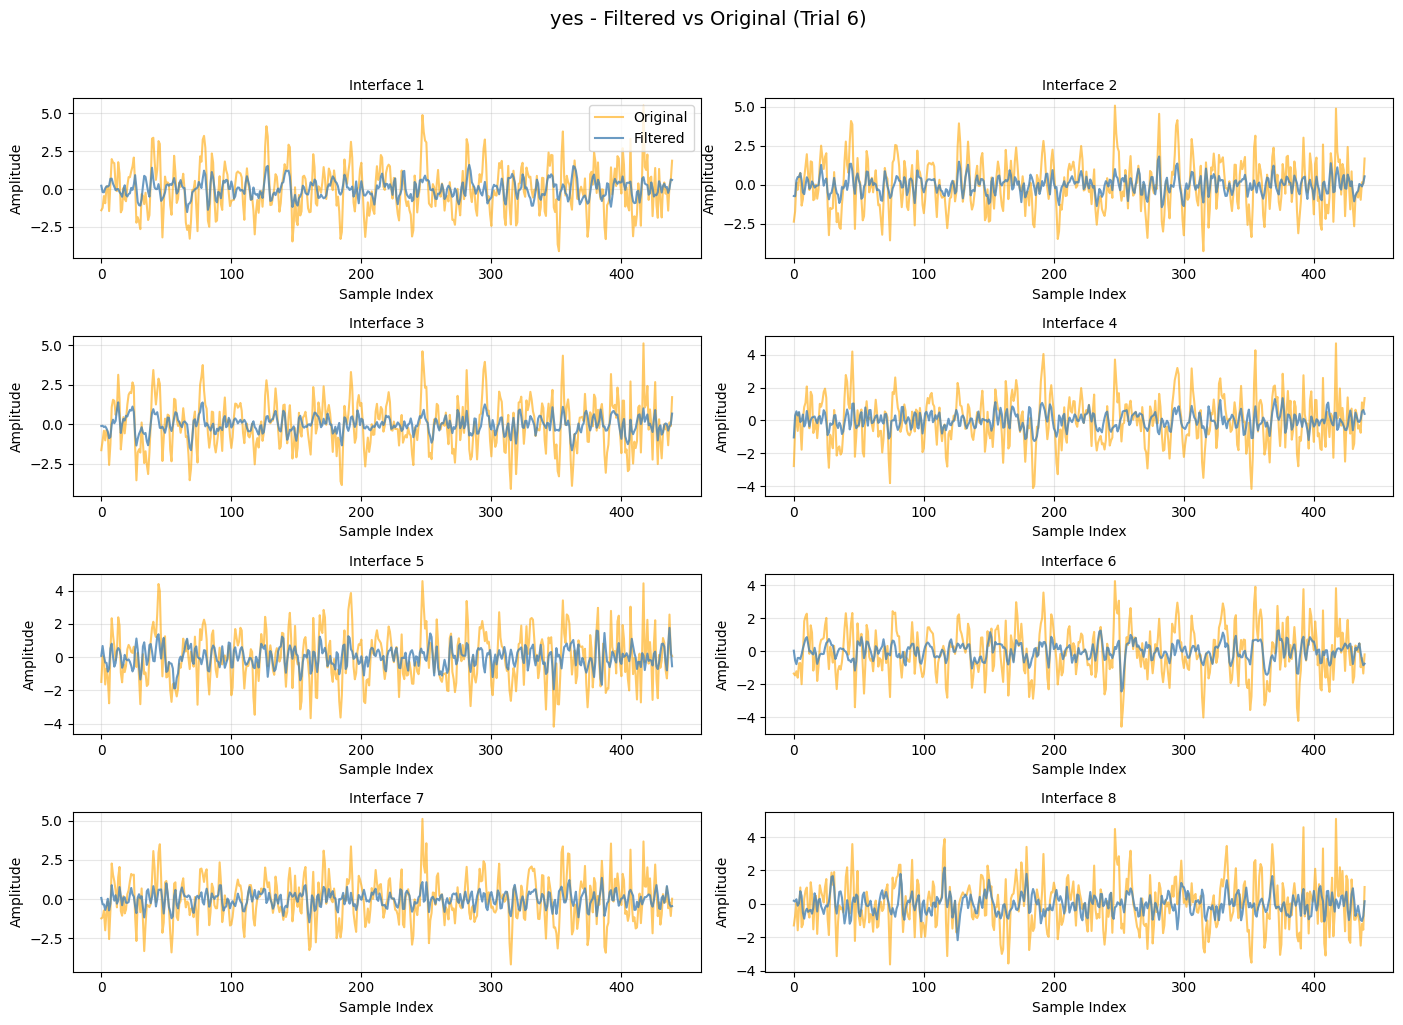



TRIAL INDEX = 7


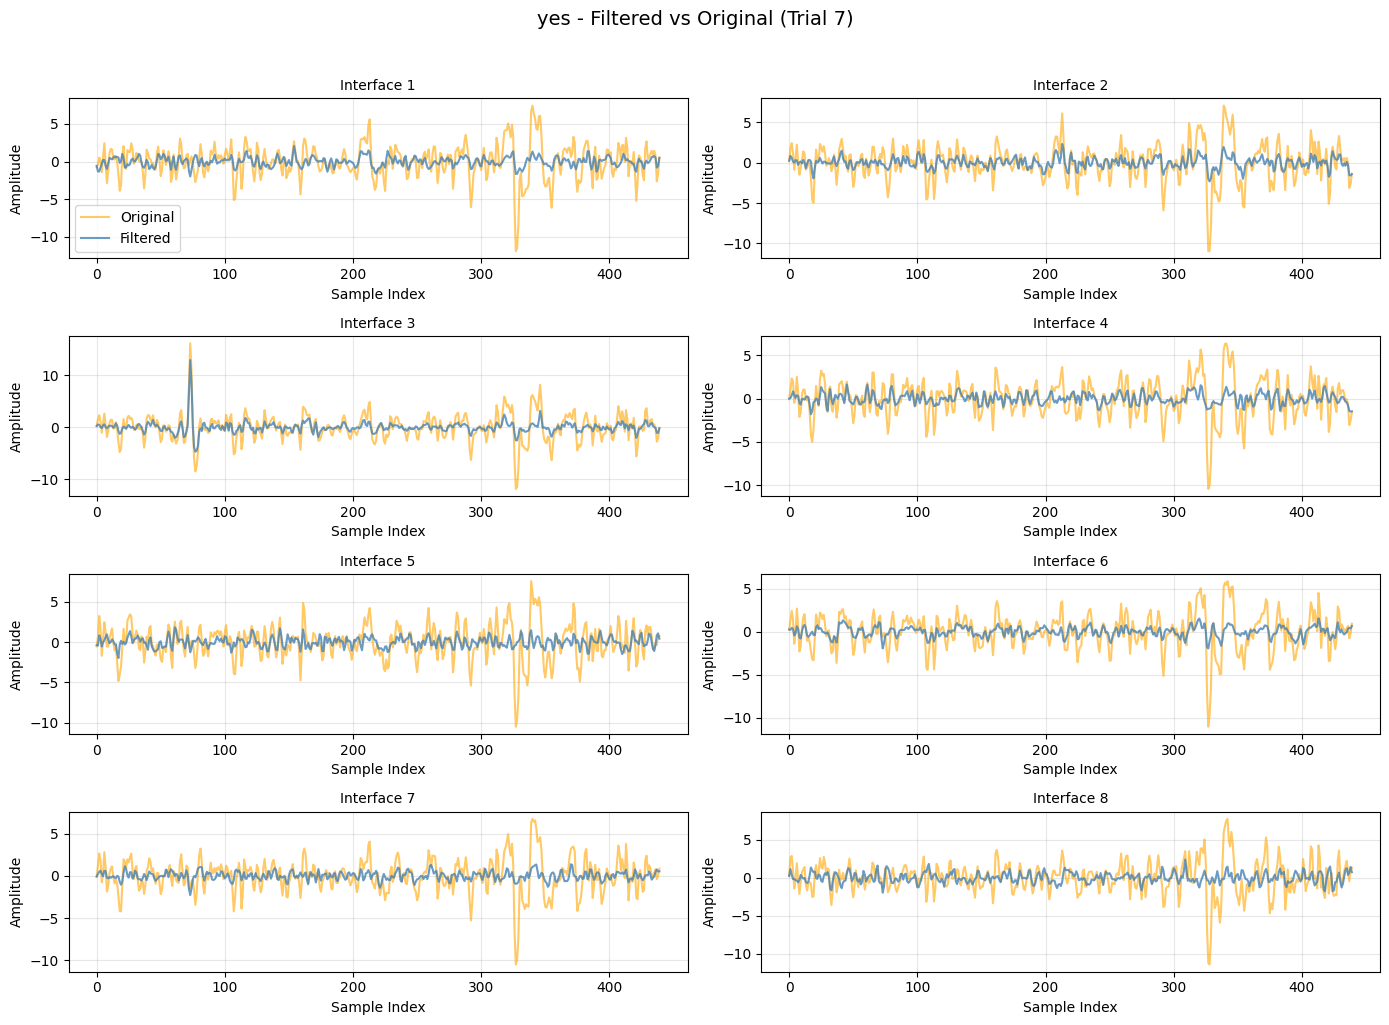



TRIAL INDEX = 8


KeyboardInterrupt: 

In [ ]:
for i in range(len(filtered_data)):
  print(f"TRIAL INDEX = {i}")
  plot_filtered_vs_original(data, filtered_data, trial_idx=i, label_name= filtered_data.iloc[i]["label"])
  print()
  print()



#Data-Augmentation Here!!!


# Task
Add an RNN-LSTM neural network to the notebook, train it on the filtered EEG data with a 70/10/20 train/validation/test split, include comments describing the model and how to configure it, and perform hyperparameter and parameter tuning.

## Prepare data

### Subtask:
Split the filtered data into training, validation, and testing sets (70% train, 10% validation, 20% test). Reshape the data for input into the RNN-LSTM model.


**Reasoning**:
Import necessary libraries and split the data into training, validation, and testing sets, then reshape the data and convert labels for the RNN-LSTM model.



In [55]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np

SEED = 88
# -----------------------------
# 🔹 Generalized EEG Augmentation Function
# -----------------------------
def augment_eeg_tensor(
    eeg_tensor: torch.Tensor,
    target_len: int = 500,
    max_shift: int = 20,
    noise_level: float = 0.02,
    time_warp_range: float = 0.1,
    scale_range: float = 0.1,
    channel_dropout_prob: float = 0.1,
    seed: int = SEED
):
    """
    Augments EEG signals (batch, time, channels) using:
    - jitter (time shift)
    - additive noise
    - time warping (stretch/compress)
    - random scaling
    - channel dropout
    Returns a list of augmented tensors (same shape as input).
    """
    rng = np.random.default_rng(seed)
    eeg_np = eeg_tensor.detach().cpu().numpy()
    if eeg_np.ndim == 2:
        eeg_np = np.expand_dims(eeg_np, axis=0)  # -> (1, time, channels)

    aug_list = []

    def _resample(signal, new_len):
        orig_len = signal.shape[0]
        if orig_len == new_len:
            return signal.copy()
        orig_idx = np.linspace(0, orig_len - 1, orig_len)
        new_idx = np.linspace(0, orig_len - 1, new_len)
        return np.stack([np.interp(new_idx, orig_idx, signal[:, ch]) for ch in range(signal.shape[1])], axis=1)

    for trial in eeg_np:
        # Pad/truncate to target length
        time_len = trial.shape[0]
        if time_len < target_len:
            trial = np.pad(trial, ((0, target_len - time_len), (0, 0)), mode="constant")
        base = trial[:target_len]

        aug_trials = [base]

        # 1️⃣ Time jitter (shift)
        for _ in range(2):
            shift = int(rng.integers(-max_shift, max_shift + 1))
            start = np.clip(shift, 0, max(0, time_len - target_len))
            aug_trials.append(trial[start:start + target_len])

        # 2️⃣ Additive noise
        for _ in range(2):
            noise = rng.normal(scale=noise_level, size=base.shape) * (np.std(base, axis=0, keepdims=True) + 1e-8)
            aug_trials.append(base + noise)

        # # 3️⃣ Time warp (stretch/compress)
        # scale = rng.uniform(1.0 - time_warp_range, 1.0 + time_warp_range)
        # stretched_len = max(10, int(round(base.shape[0] * scale)))
        # stretched = _resample(base, stretched_len)
        # aug_trials.append(_resample(stretched, target_len))

        # # 4️⃣ Random amplitude scaling
        # scale_factor = rng.uniform(1.0 - scale_range, 1.0 + scale_range)
        # aug_trials.append(base * scale_factor)

        # 5️⃣ Random channel dropout
        dropout = base.copy()
        mask = rng.uniform(size=dropout.shape[1]) > channel_dropout_prob
        dropout *= mask
        aug_trials.append(dropout)

        aug_list.extend(aug_trials)

    # Convert back to torch tensors
    aug_tensors = [torch.tensor(a, dtype=eeg_tensor.dtype) for a in aug_list]
    return aug_tensors



# -----------------------------
# 🔹 Data Preparation
# -----------------------------
# Convert the list of dataframes to a single numpy array for splitting
X = np.stack([df.iloc[:, :8].values for df in filtered_data["data"]])
y = filtered_data["label_id"].values

# Split data into training (80%), validation (5%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=SEED, stratify=y_temp
)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Before augmentation:")
print("Training data shape:", X_train_tensor.shape)

# -----------------------------
# 🔹 Apply Data Augmentation to Training Set
# -----------------------------
augmented_samples = []
augmented_labels = []

# for i in range(len(X_train_tensor)):
#     augmented = augment_eeg_tensor(X_train_tensor[i], target_len=440)

#     augmented_samples.extend(augmented)
#     augmented_labels.extend([y_train_tensor[i].item()] * len(augmented))

# Convert to tensors and concatenate
# augmented_tensor = torch.stack(augmented_samples)
# augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

# Combine original and augmented training data
# X_train_tensor = torch.cat([X_train_tensor, augmented_tensor])
# y_train_tensor = torch.cat([y_train_tensor, augmented_labels])

print("After augmentation:")
print("Training data shape:", X_train_tensor.shape)
print("Training labels shape:", y_train_tensor.shape)

# -----------------------------
# 🔹 Dataset and Dataloader
# -----------------------------
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

batch_size = 16

train_dataset = EEGDataset(X_train_tensor, y_train_tensor)
val_dataset = EEGDataset(X_val_tensor, y_val_tensor)
test_dataset = EEGDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Before augmentation:
Training data shape: torch.Size([125, 440, 8])
After augmentation:
Training data shape: torch.Size([125, 440, 8])
Training labels shape: torch.Size([125])


In [56]:
# Function to print counts per class
def print_label_counts(y_tensor, dataset_name="Dataset"):
    counts = torch.bincount(y_tensor)
    for i, count in enumerate(counts):
        print(f"{dataset_name} - Class {i}: {count} samples")
    print(f"Total samples in {dataset_name}: {len(y_tensor)}\n")

# Print counts for each split
print_label_counts(y_train_tensor, "Training")
print_label_counts(y_val_tensor, "Validation")
print_label_counts(y_test_tensor, "Test")


Training - Class 0: 49 samples
Training - Class 1: 48 samples
Training - Class 2: 28 samples
Total samples in Training: 125

Validation - Class 0: 7 samples
Validation - Class 1: 7 samples
Validation - Class 2: 4 samples
Total samples in Validation: 18

Test - Class 0: 14 samples
Test - Class 1: 14 samples
Test - Class 2: 8 samples
Total samples in Test: 36



## Define RNN-LSTM model

### Subtask:
Define the architecture of the RNN-LSTM model using PyTorch. Include comments to describe the model and explain how to configure it.

**Reasoning**:
Define a simple RNN-LSTM model for binary classification using PyTorch's `nn.Module`. The model will consist of an LSTM layer followed by a fully connected layer for outputting the class probabilities.

In [58]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

class EEG_LSTM(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2, num_classes=4, dropout=0.60):
        super(EEG_LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.ln = nn.LayerNorm(hidden_size)

        # Simple attention layer
        self.attn = nn.Linear(hidden_size, 1)

        # Fully connected classification head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.RReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)

        # Compute attention weights
        scores = self.attn(out).squeeze(-1)       # (batch, seq_len)
        weights = torch.softmax(scores, dim=1)    # (batch, seq_len)

        # Weighted sum over time
        out = (out * weights.unsqueeze(-1)).sum(dim=1)  # (batch, hidden_size)
        out = self.ln(out)

        return self.fc(out)

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Model configuration
input_size = X_train_tensor.shape[2]  # Number of features (8 EEG channels)
hidden_size = 48  # Number of hidden units in LSTM - can be tuned
num_layers =  2  # Number of LSTM layers - can be tuned
output_size = 3 # Number of output classes (yes/no/food/water/bg_noise)

model = EEG_LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Suitable for binary classification with two classes
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

print("Model defined:")
print(model)

Model defined:
EEG_LSTM(
  (lstm): LSTM(8, 48, num_layers=2, batch_first=True, dropout=0.6)
  (ln): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (attn): Linear(in_features=48, out_features=1, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=3, bias=True)
  )
)



Training the model on cuda...

Epoch [001/150] | Train Loss: 1.1231 | Val Loss: 1.0760 | Val Acc: 38.89%
Epoch [002/150] | Train Loss: 1.0640 | Val Loss: 1.0614 | Val Acc: 38.89%
Epoch [003/150] | Train Loss: 1.1080 | Val Loss: 1.0597 | Val Acc: 38.89%
Epoch [004/150] | Train Loss: 1.0711 | Val Loss: 1.0137 | Val Acc: 44.44%
Epoch [005/150] | Train Loss: 0.9890 | Val Loss: 0.9657 | Val Acc: 50.00%
Epoch [006/150] | Train Loss: 0.8906 | Val Loss: 1.0079 | Val Acc: 55.56%
Epoch [007/150] | Train Loss: 0.8849 | Val Loss: 0.9162 | Val Acc: 50.00%
Epoch [008/150] | Train Loss: 0.8197 | Val Loss: 0.8868 | Val Acc: 50.00%
Epoch [009/150] | Train Loss: 0.7419 | Val Loss: 0.7581 | Val Acc: 44.44%
Epoch [010/150] | Train Loss: 0.7591 | Val Loss: 0.7968 | Val Acc: 50.00%
Epoch [011/150] | Train Loss: 0.7631 | Val Loss: 0.6801 | Val Acc: 55.56%
Epoch [012/150] | Train Loss: 0.7247 | Val Loss: 0.8038 | Val Acc: 55.56%
Epoch [013/150] | Train Loss: 0.7135 | Val Loss: 0.6499 | Val Acc: 66.67%
Epoch 

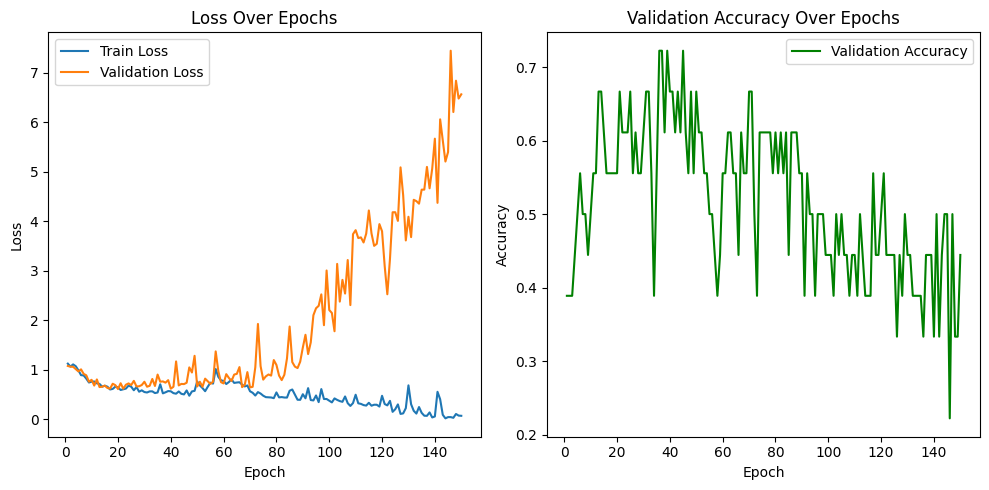

In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

num_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"\nTraining the model on {device}...\n")

# --- Track metrics ---
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # -------------------
    # TRAINING
    # -------------------
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # -------------------
    # VALIDATION
    # -------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # --- Logging ---
    print(f"Epoch [{epoch:03d}/{num_epochs}]"
          f" | Train Loss: {epoch_loss:.4f}"
          f" | Val Loss: {epoch_val_loss:.4f}"
          f" | Val Acc: {val_accuracy*100:.2f}%")

print("\n✅ Finished Training!")

# -------------------
# TEST EVALUATION
# -------------------
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
test_acc = correct / total
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

# -------------------
# PLOTTING
# -------------------
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate the model

### Subtask:
Evaluate the trained model on the test set to assess its performance.

**Reasoning**:
Evaluate the trained PyTorch RNN-LSTM model on the test set to calculate accuracy and generate a confusion matrix to visualize the classification results.

Test Loss: 3.5827, Test Accuracy: 0.6667


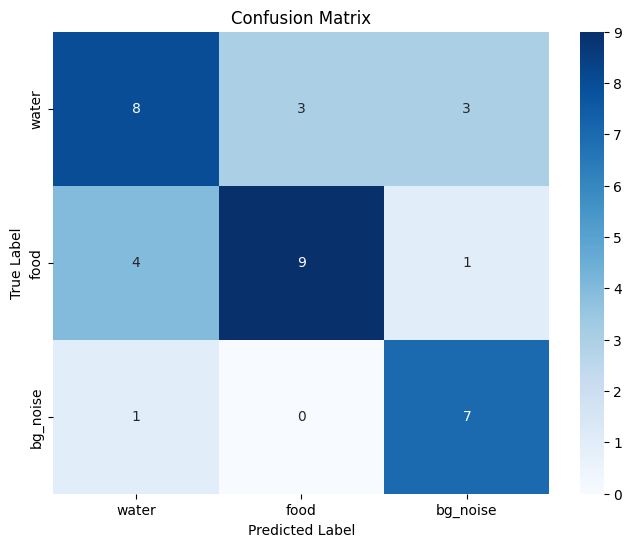

In [66]:
# Evaluate the model on the test set
model.eval() # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
test_loss /= len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["water" ,"food", "bg_noise"], yticklabels=["water", "food", "bg_noise"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [73]:
PATH = "/content/models/three_class_classifier_70P_WFB.pth"
torch.save(model.state_dict(), PATH)



Test Model on NEW DATA

In [71]:
!mkdir /content/models